In [ ]:
##This block is only for access of files using google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import cv2;
import matplotlib.pyplot as plt

import numpy as np;
from random import shuffle;
import cv2;
from random import shuffle;
from tqdm import tqdm;
import tensorflow;
from tensorflow.keras import layers;
from tensorflow.keras import Model;
from tensorflow.keras.optimizers import SGD;


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
train_Data_File = drive.CreateFile({'id': '11UzJtoYiSvlIfUmXB__BnAcAJKqosiV8'});
train_Data_File.GetContentFile('Nerve_Segmentation_Data.zip');

In [ ]:
!unzip 'Nerve_Segmentation_Data.zip'

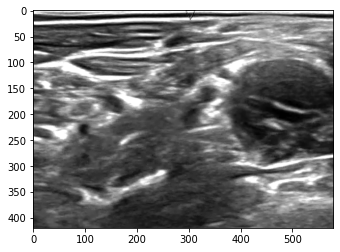

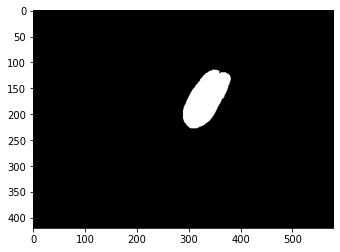

In [ ]:
from PIL import Image
im = np.array(Image.open("9_98.tif"))
im_mask = np.array(Image.open("9_98_mask.tif"))
plt.imshow(im, cmap='gray')
plt.show()
plt.imshow(im_mask, cmap='gray')

In [ ]:
#Resizing the images and masks and normalizing

import glob
from tqdm import tqdm;
ImSize = 144;
image_Array = np.zeros((len(glob.glob("*_mask.tif")),ImSize, ImSize))
mask_Array = np.zeros((len(glob.glob("*_mask.tif")),ImSize, ImSize))
file_Names = set();
count = 0;
for file in tqdm(glob.glob("*_mask.tif")):
  f_Name = file.split("_mask.tif")[0]
  file_Names.add(f_Name)
  I = np.array(Image.open(f_Name+".tif").resize((ImSize,ImSize)));
  image_Array[count,:,:] = I/255;
  I = np.array(Image.open(f_Name+"_mask.tif").resize((ImSize,ImSize)));
  mask_Array[count,:,:] = I/255;
  count = count+1;

100%|██████████| 5635/5635 [00:44<00:00, 127.04it/s]


**Question:**


Accurately identifying nerve structures in ultrasound images is a critical step in effectively inserting a patient’s pain management catheter. In this you are challenged to build a model that can identify nerve structures in a dataset of ultrasound images of the neck. Doing so would improve catheter placement and contribute to a more pain free future. 

The task in this competition is to segment a collection of nerves called the Brachial Plexus (BP) in ultrasound images. You are provided with a large training set of images where the nerve has been manually annotated by humans. Annotators were trained by experts and instructed to annotate images where they felt confident about the existence of the BP landmark.

Make an autoencoder model to perform automatic segmentation of the BP in ultrasound images.

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(144, 144, 1))  

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(1,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((3,3),  padding='same')(x)
encoded = Conv2D(1,(3,3),activation='relu', padding= 'same')(x)

x = UpSampling2D((3, 3))(encoded)
x = Conv2DTranspose(1, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2DTranspose(1,(3,3),activation='relu',padding='same')(x)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()
encoder.summary()
print(encoded.shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 144, 144, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 144, 144, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 4)         292       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 4)         0     

In [ ]:
#performing a train set and test set split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(image_Array,mask_Array, test_size=0.2)

In [ ]:
# fitting autoencoder
autoencoder.fit(X_train,Y_train,epochs=50,batch_size=1024, shuffle= True)

Epoch 1/50
5/5 [==============================] - 40s 782ms/step - loss: 0.1859
Epoch 2/50
5/5 [==============================] - 2s 333ms/step - loss: 0.1848
Epoch 3/50
5/5 [==============================] - 2s 339ms/step - loss: 0.1798
Epoch 4/50
5/5 [==============================] - 2s 335ms/step - loss: 0.1839
Epoch 5/50
5/5 [==============================] - 2s 329ms/step - loss: 0.1844
Epoch 6/50
5/5 [==============================] - 2s 337ms/step - loss: 0.1834
Epoch 7/50
5/5 [==============================] - 2s 337ms/step - loss: 0.1822
Epoch 8/50
5/5 [==============================] - 2s 338ms/step - loss: 0.1859
Epoch 9/50
5/5 [==============================] - 2s 337ms/step - loss: 0.1792
Epoch 10/50
5/5 [==============================] - 2s 333ms/step - loss: 0.1828
Epoch 11/50
5/5 [==============================] - 2s 332ms/step - loss: 0.1825
Epoch 12/50
5/5 [==============================] - 2s 334ms/step - loss: 0.1825
Epoch 13/50
5/5 [==============================]

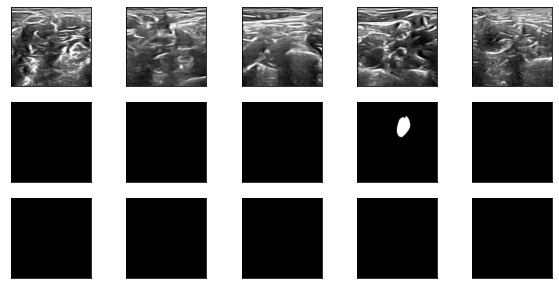

In [ ]:
# Plotting 
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(image_Array)

n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(image_Array[i].reshape(ImSize,ImSize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(mask_Array[i].reshape(ImSize,ImSize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1+2*n)
    plt.imshow(decoded_imgs[i].reshape(ImSize, ImSize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()